In [1]:
import torch.nn as nn
import torch
import rawpy
import numpy as np
from torch.utils.data import DataLoader
from utils.datasets import LabeledDataset

import torchvision.transforms as transforms

import ignite.distributed as idist
from ignite.engine import Engine, Events
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import FID, InceptionScore, RunningAverage

from torch.profiler import profile, record_function, ProfilerActivity

from torchinfo import summary

In [2]:
root_dir = "dataset"
sony_csv_files = ["dataset/Sony_train_list.txt"]
fuji_csv_files =  ["dataset/Fuji_train_list.txt"]

batch_size = 8
input_size = 512

pre_crop_transform = transforms.Compose([
    transforms.ToTensor()
])

sony_dataset = LabeledDataset(root_dir, *sony_csv_files, transform=pre_crop_transform)
sony_dataloader = idist.auto_dataloader(sony_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True, prefetch_factor=1)
print(sony_dataset[0][0].shape)
print(sony_dataset[0][1].shape)

2023-06-06 08:47:17,741 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<utils.datasets.Labe': 
	{'batch_size': 8, 'num_workers': 8, 'shuffle': True, 'drop_last': True, 'prefetch_factor': 1, 'pin_memory': True}


what?
torch.Size([1, 2848, 4256])
torch.Size([3, 2848, 4256])


In [3]:
sony_dataset.prime_buffer()

In [4]:
# from unet.unet_model import UNet
from torch import optim 
from ignite.handlers.param_scheduler import LRScheduler

class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(ConvBlock, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channel, out_channel, 3, padding=1)
        self.lrelu1_1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv1_2 = nn.Conv2d(out_channel, out_channel, 3, padding=1)
        self.lrelu1_2 = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.conv1_1(x)
        x = self.lrelu1_1(x)
        x = self.conv1_2(x)
        x = self.lrelu1_2(x)
        return x
    
class UpConcatBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UpConcatBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channel, in_channel // 2, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channel, out_channel)

    def forward(self, x1, x2):
        x1 = self.deconv(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv_block(x)

class UNet(nn.Module):
    def __init__(self, in_feat):
        super(UNet, self).__init__()
        
        self.down1 = ConvBlock(in_feat, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = ConvBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = ConvBlock(128, 256)
        self.pool4 = nn.MaxPool2d(2)
        self.down5 = ConvBlock(256, 512)

        self.up5 = UpConcatBlock(512, 256)
        self.up4 = UpConcatBlock(256, 128)
        self.up3 = UpConcatBlock(128, 64)
        self.up2 = UpConcatBlock(64, 32)

        self.conv10 = nn.Conv2d(32, 12, 1)

    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(self.pool1(down1))
        down3 = self.down3(self.pool2(down2))
        down4 = self.down4(self.pool3(down3))
        down5 = self.down5(self.pool4(down4))

        up = self.up5(down5, down4)
        up = self.up4(up, down3)
        up = self.up3(up, down2)
        up = self.up2(up, down1)

        out = self.conv10(up)
        out = torch.nn.functional.pixel_shuffle(out, 2)
        return out

net = UNet(4)
model = idist.auto_model(net)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss = nn.L1Loss()
lr_scheduler = LRScheduler(optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8))

2023-06-06 08:48:20,632 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


In [5]:
input_data = torch.randn(batch_size, 4, input_size, input_size)
summary(model, input_data = input_data)

Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [8, 3, 1024, 1024]        --
├─UNet: 1-1                              [4, 3, 1024, 1024]        7,760,748
├─UNet: 1-4                              --                        (recursive)
│    └─ConvBlock: 2-1                    [4, 32, 512, 512]         10,432
│    └─ConvBlock: 2-26                   --                        (recursive)
│    │    └─Conv2d: 3-1                  [4, 32, 512, 512]         1,184
├─UNet: 1-3                              [4, 3, 1024, 1024]        --
├─UNet: 1-4                              --                        (recursive)
│    └─ConvBlock: 2-3                    [4, 32, 512, 512]         --
│    └─ConvBlock: 2-26                   --                        (recursive)
│    │    └─Conv2d: 3-2                  [4, 32, 512, 512]         --
│    │    └─LeakyReLU: 3-3               [4, 32, 512, 512]         --
│    │    └─Conv2d: 3-4            

In [6]:
def random_crop(image_short, image_long, size):
    H = image_short.shape[2]
    W = image_short.shape[3]
    ps = size
    xx = np.random.randint(0, W - ps)
    yy = np.random.randint(0, H - ps)
    image_short = image_short[:,:,yy:yy + ps, xx:xx + ps]
    image_long = image_long[:,:,yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2]
    return image_short, image_long

def pack_sony_raw(batch, device=None):
    if not device:
        device = idist.device()
    batch = torch.maximum(batch - 512, torch.Tensor([0]).to(device=device)) / (16383 - 512)
    H = batch.shape[2]
    W = batch.shape[3]

    out = torch.cat((batch[:,:, 0:H:2, 0:W:2], 
                     batch[:,:, 0:H:2, 1:W:2],
                     batch[:,:, 1:H:2, 1:W:2],
                     batch[:,:, 1:H:2, 0:W:2]), dim=1)
    return out

In [7]:
def training_step(engine, batch):
    model.train()
    optimizer.zero_grad()

    # with record_function("get_batch"):
    short, long, ratio, cam_model, exposure_ratio, _, _ = batch

    # with record_function("transfer"):
    short = short.to(idist.device())
    long = long.to(idist.device())

    # with record_function("pack_sony_raw"):
    short = pack_sony_raw(short)

    # with record_function("preprocess"):
    long = long / 65535.0
    short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)
    short, long = random_crop(short, long, input_size)

    # with record_function("forward"):
    output = model(short)

    # with record_function("loss"):
    g_loss = loss(output, long)
        
    g_loss.backward()
    optimizer.step()
    return {"Loss_G": g_loss.item()}

In [8]:
trainer = Engine(training_step)
trainer.add_event_handler(Events.EPOCH_STARTED, lr_scheduler)
RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
ProgressBar().attach(trainer, metric_names=['Loss_G'])

G_losses = []

@trainer.on(Events.EPOCH_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    print(o["Loss_G"])
    G_losses.append(o["Loss_G"])

/home/pikachu/.local/lib/python3.10/site-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [9]:
num_epoch = 100
def training(*args):
    # with profile(activities=[ProfilerActivity.CPU], record_shapes=True, profile_memory=True, with_stack=True) as prof:
    trainer.run(sony_dataloader, max_epochs=num_epoch)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=100))
    # print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=100))
    # prof.export_chrome_trace("trace.json")
    # https://github.com/pytorch/pytorch/issues/100253
    # prof.export_stacks("profiler_stacks.txt", "self_cpu_time_total")

with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)


2023-06-06 08:48:23,976 ignite.distributed.launcher.Parallel INFO: Initialized processing group with backend: 'nccl'
2023-06-06 08:48:23,977 ignite.distributed.launcher.Parallel INFO: - Run '<function training at 0x7ff499164160>' in 1 processes


0.07431729882955551


0.06290750205516815


0.06893424689769745


0.08531945943832397


0.05875550955533981


0.05586516112089157


0.0676441490650177


0.0693594440817833


0.05865857005119324


0.04564635083079338


0.04711239039897919


0.07065163552761078


0.05157119780778885


0.06649608165025711


0.05148058384656906


0.05311661213636398


0.05202290415763855


0.03723089024424553


0.04714794084429741


0.03646356612443924


0.04692711681127548


0.048703841865062714


0.03587149828672409


0.042478978633880615


0.05284067243337631


0.04544060677289963


0.04100693389773369


0.047753892838954926


0.05210046097636223


0.042723558843135834


0.03138866275548935


0.04370070993900299


0.038904257118701935


0.04468048736453056


0.04549228399991989


0.04383949935436249


0.03811232000589371


0.05127429962158203


0.03161833435297012


0.03498060256242752


0.04803740233182907


0.03339596837759018


0.047418057918548584


0.03753842040896416


0.03677302226424217


0.04413118213415146


0.038014184683561325


0.05581230670213699


0.03977331519126892


0.06132715195417404


0.03523804619908333


0.03708121180534363


0.04382845759391785


0.04585381597280502


0.03490680456161499


0.039105433970689774


0.03550798073410988


0.04520663246512413


0.036418281495571136


0.04140540957450867


0.03361786901950836


0.026348233222961426


0.03370363265275955


0.039533037692308426


0.04747496545314789


0.04063580557703972


0.027335498481988907


0.02710147760808468


0.03937413915991783


0.0436113104224205


0.03152799606323242


0.03176747262477875


0.041503433138132095


0.044511161744594574


0.0337822288274765


0.028741490095853806


0.035460200160741806


0.03573602810502052


0.03849698603153229


0.04129209741950035


0.040197499096393585


0.04416745901107788


0.03994676470756531


0.03706631436944008


0.031843237578868866


0.02477872371673584


0.028744056820869446


0.02754535898566246


0.030482469126582146


0.026624977588653564


0.04087219387292862


0.04181041568517685


0.028910253196954727


0.03780980035662651


0.03461301699280739


0.027879437431693077


0.03398529440164566


0.028616756200790405


0.039886295795440674


0.03130226954817772


2023-06-06 13:17:40,030 ignite.distributed.launcher.Parallel INFO: End of run
2023-06-06 13:17:40,031 ignite.distributed.launcher.Parallel INFO: Finalized processing group with backend: 'nccl'


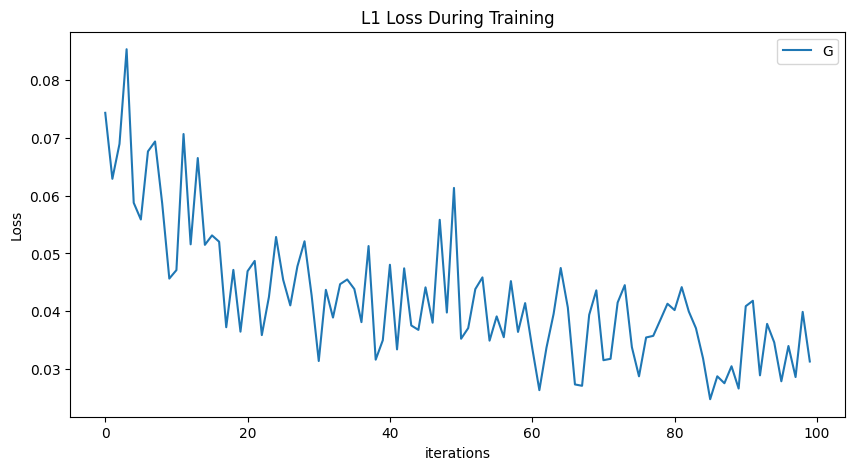

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("L1 Loss During Training")
plt.plot(G_losses,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

In [11]:
torch.save({
            'epoch': num_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'model_seed_{}.pt'.format(torch.random.initial_seed()))

In [12]:
import cv2

# Load best model
# checkpoint = torch.load('model_seed_{}.pt'.format(8685042128796837027))
checkpoint = torch.load('model_seed_{}.pt'.format(torch.random.initial_seed()))
best_model = idist.auto_model(
    UNet(4)
)

best_model.load_state_dict(checkpoint['model_state_dict'])

root_dir = "dataset"
sony_test_csv_files = ["dataset/Sony_test_list.txt"]

sony_test_dataset = LabeledDataset(root_dir, *sony_test_csv_files, transform=transforms.Compose([
    transforms.ToTensor()
]))
sony_test_dataloader = DataLoader(sony_test_dataset, batch_size=1, num_workers=1)


2023-06-06 13:17:41,108 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


what?
tensor(9.9451e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')
tensor(0.0249, device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(250., device='cuda:0')
0.17483068 0.13768703 0.0 1.0
0.1554999 0.12671766 0.0 1.0
0.12286426 0.09487379 0.0 1.0
0.1745267 0.13415731 0.0 1.0
0.15320197 0.12263676 0.0 1.0
0.11769672 0.09105058 0.0 1.0


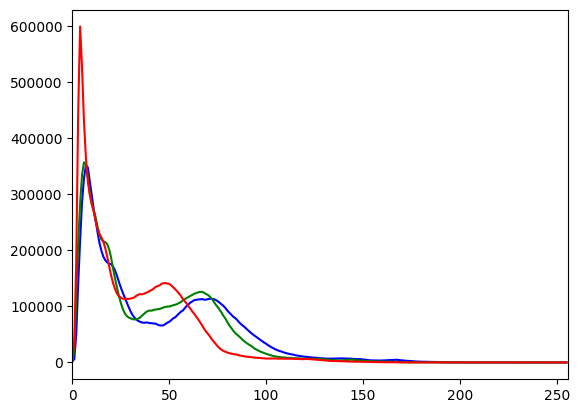

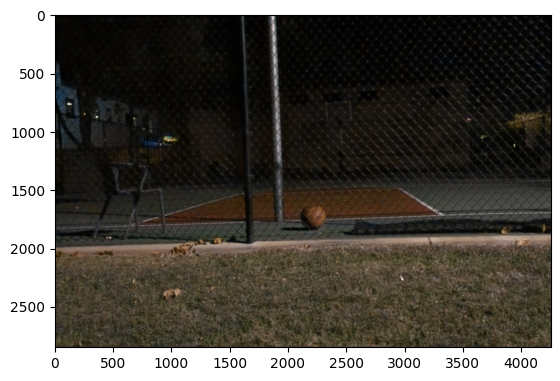

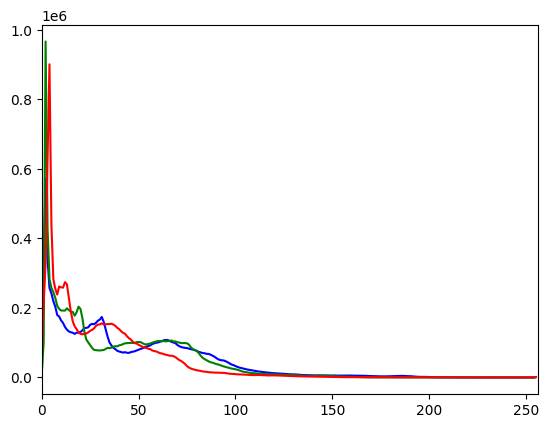

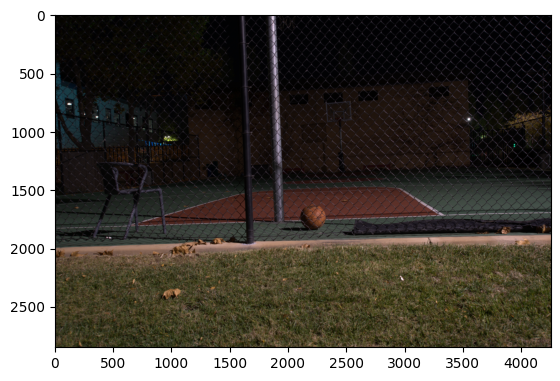

In [13]:
import matplotlib.pyplot as plt

with torch.no_grad():
    best_model.eval()
    batch = next(iter(sony_test_dataloader))
    short, long, ratio, cam_model, exposure_ratio, _, _ = batch
    short = short.to(idist.device())
    long = long.to(idist.device())

    short = pack_sony_raw(short)
    print(torch.mean(short), torch.median(short), torch.min(short), torch.max(short))
    long = long / 65535.0
    short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)
    print(torch.mean(short), torch.median(short), torch.min(short), torch.max(short))
    
    
    output = best_model(short)
    # output = torch.nn.functional.pixel_shuffle(output, 2)

    output = output[0, :, :, :].to('cpu').numpy()
    output = np.minimum(np.maximum(output, 0), 1)
    gt_full = long[0, :, :, :].to('cpu').numpy()

    print(np.mean(output[0]), np.median(output[0]), np.min(output[0]), np.max(output[0]))
    print(np.mean(output[1]), np.median(output[1]), np.min(output[1]), np.max(output[1]))
    print(np.mean(output[2]), np.median(output[2]), np.min(output[2]), np.max(output[2]))
    print(np.mean(gt_full[0]), np.median(gt_full[0]), np.min(gt_full[0]), np.max(gt_full[0]))
    print(np.mean(gt_full[1]), np.median(gt_full[1]), np.min(gt_full[1]), np.max(gt_full[1]))
    print(np.mean(gt_full[2]), np.median(gt_full[2]), np.min(gt_full[2]), np.max(gt_full[2]))

    output = np.minimum(np.transpose(output, (1,2,0)) * 255, 255).astype(np.uint8)
    # output = (output-np.min(output))/(np.max(output)-np.min(output))
    gt_full = np.minimum(np.transpose(gt_full, (1,2,0)) * 255, 255).astype(np.uint8)

    color = ('b','g','r')
    plt.figure()
    for i,col in enumerate(color):
        histr = cv2.calcHist([output],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.show()
    plt.figure()
    plt.imshow(output)

    plt.figure()
    for i,col in enumerate(color):
        histr = cv2.calcHist([gt_full],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.show()

    plt.figure()
    plt.imshow(gt_full)